In [1]:
import pandas as pd 
all_results = []
device = "cuda:0"
clip_backbone = "ViT-L/14"


In [3]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from pytorch_ood.loss import DeepSVDDLoss
from pytorch_ood.utils import OODMetrics, ToUnknown

In [4]:
import numpy as np 
import torch 

with np.load("x-test.npz") as data:
    x_test = torch.tensor(data['arr_0'])
    
with np.load("x-train.npz") as data:
    x_train = torch.tensor(data['arr_0'])
    
with np.load("y-test.npz") as data:
    y_test = torch.tensor(data['arr_0'])
    y_test = torch.where(y_test.sum(dim=1) == 20, 0, -1)
    # y_test = torch.where(y_test == 20, 0, -1)

In [5]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(x_train.unsqueeze(1))
train_loader = DataLoader(train_dataset, num_workers=5, batch_size=128, shuffle=True)

test_dataset = TensorDataset(x_test.unsqueeze(1), y_test)

test_loader = DataLoader(test_dataset, shuffle=False, num_workers=5, batch_size=256)

# Deep OC-SVDD

In [6]:
class Model(nn.Module):
    """ """
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, padding=1, bias=False)
        self.pool = nn.MaxPool2d(2)
        self.c2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.c3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.layer5 = nn.Linear(3136, 128, bias=False)
        self.layer6 = nn.Linear(128, 2, bias=False)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.c1(x).relu()
        x = self.pool(x)
        x = self.c2(x).relu()
        x = self.pool(x)
        x = self.c3(x).relu()
        x = self.pool(x)
        x = x.reshape(batch_size, -1)
        x = self.layer5(x).relu()
        x = self.layer6(x)
        return x


In [7]:
model = Model().to(device)

opti = Adam(model.parameters(), lr=0.001)

with torch.no_grad():
    d = [model(x[0].to(device)) for x in train_loader]
    center = torch.concat(d).mean(dim=0).cpu()

criterion = DeepSVDDLoss(n_dim=2, center=center).to(device)

In [8]:
def test():
    model.eval()
    metrics = OODMetrics()
    with torch.no_grad():
        for x, y in test_loader:
            z = model(x.to(device))
            # calculate (squared) distance of points to the center in output space
            distances = criterion.distance(z)
            # dists.append(distances)
            # labels.append(y)
            # print(y)
            metrics.update(distances, y)
    
    m = metrics.compute()
    # print(metrics.compute())
    model.train()
    return m 


In [9]:
for epoch in range(20):
    for x in train_loader:
        z = model(x[0].to(device))
        # since this is a one-class method, we do not have to provide any class labels
        loss = criterion(z)
        opti.zero_grad()
        loss.backward()
        opti.step()

    m = test()
    print(f"Epoch {epoch}, {m}")

m.update({"Method": "Deep SVDD", "Backbone": "-"})
all_results.append(m)

Epoch 0, {'AUROC': 0.5085565447807312, 'AUPR-IN': 0.18896059691905975, 'AUPR-OUT': 0.8184113502502441, 'FPR95TPR': 0.9514999985694885}
Epoch 1, {'AUROC': 0.502327561378479, 'AUPR-IN': 0.18578612804412842, 'AUPR-OUT': 0.8166112303733826, 'FPR95TPR': 0.9491999745368958}
Epoch 2, {'AUROC': 0.49871140718460083, 'AUPR-IN': 0.18396472930908203, 'AUPR-OUT': 0.8147433400154114, 'FPR95TPR': 0.953000009059906}
Epoch 3, {'AUROC': 0.5026273131370544, 'AUPR-IN': 0.1858845204114914, 'AUPR-OUT': 0.8150936365127563, 'FPR95TPR': 0.9584000110626221}
Epoch 4, {'AUROC': 0.5048190355300903, 'AUPR-IN': 0.18722626566886902, 'AUPR-OUT': 0.8150094747543335, 'FPR95TPR': 0.9559000134468079}
Epoch 5, {'AUROC': 0.5058260560035706, 'AUPR-IN': 0.18797431886196136, 'AUPR-OUT': 0.8156285285949707, 'FPR95TPR': 0.9567000269889832}
Epoch 6, {'AUROC': 0.5055065155029297, 'AUPR-IN': 0.18745185434818268, 'AUPR-OUT': 0.8153392672538757, 'FPR95TPR': 0.9532999992370605}
Epoch 7, {'AUROC': 0.5028736591339111, 'AUPR-IN': 0.18606

# Using nearest neighbor 

In [10]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', n_jobs=-1).fit(x_train.view(-1, 56*56).numpy())

In [27]:
distances, indices = knn.kneighbors(x_test.view(-1, 56*56).numpy())

In [28]:
metrics = OODMetrics()
metrics.update(torch.tensor(distances), y_test)

m = metrics.compute()
m.update({"Method": "1-NN", "Backbone": "-"})
all_results.append(m)
print(m)

{'AUROC': 0.5, 'AUPR-IN': 0.5918367505073547, 'AUPR-OUT': 0.90816330909729, 'FPR95TPR': 1.0, 'Method': '1-NN', 'Backbone': '-'}


# Mahalanobis 

In [29]:
from sklearn.covariance import EmpiricalCovariance

cov = EmpiricalCovariance().fit(x_train.view(-1, 56*56).numpy())
distances = cov.mahalanobis(x_test.view(-1, 56*56).numpy())

metrics = OODMetrics()
metrics.update(torch.tensor(distances), y_test)
m = metrics.compute()
m.update({"Method": "Mahalanobis", "Backbone": "-"})
all_results.append(m)
print(m)

{'AUROC': 0.5, 'AUPR-IN': 0.5918367505073547, 'AUPR-OUT': 0.90816330909729, 'FPR95TPR': 1.0, 'Method': 'Mahalanobis', 'Backbone': '-'}


# Extract CLIP Features 

In [30]:
import clip

# clip.available_models()

In [31]:
clip_model, preprocess = clip.load(clip_backbone)
clip_model.cuda().eval()
input_resolution = clip_model.visual.input_resolution
context_length = clip_model.context_length
vocab_size = clip_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 424,848
Input resolution: 224
Context length: 77
Vocab size: 49408


In [32]:
# from pytorch_ood.utils import ToRGB

# i = torch.cat([ToRGB()(x) for x in x_test.unsqueeze(1)[:100]])
# image_input = torch.tensor(i).cuda()

<ipython-input-32-a7ad40ea4b4b>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_input = torch.tensor(i).cuda()


In [33]:
x_test_rgb = x_test.unsqueeze(1).repeat(1, 3, 1, 1)
x_train_rgb = x_train.unsqueeze(1).repeat(1, 3, 1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


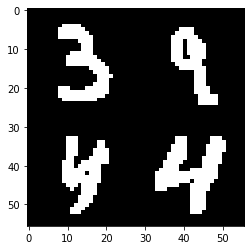

In [34]:
import matplotlib.pyplot as plt 

plt.imshow(np.moveaxis(x_test_rgb[0].numpy(), 0, -1))

In [35]:
from tqdm.notebook import tqdm 
from torchvision.transforms.functional import to_pil_image

features_test = []

with torch.no_grad():
    for i in tqdm(range(x_test_rgb.shape[0])):
        prep = preprocess(to_pil_image(x_test_rgb[i]))
        image_features = clip_model.encode_image(prep.cuda().unsqueeze(0)).float()
        features_test.append(image_features)

  0%|          | 0/12250 [00:00<?, ?it/s]

In [36]:
features_train = []

with torch.no_grad():
    for i in tqdm(range(x_train_rgb.shape[0])):
        prep = preprocess(to_pil_image(x_train_rgb[i]))
        image_features = clip_model.encode_image(prep.cuda().unsqueeze(0)).float()
        features_train.append(image_features)

  0%|          | 0/60000 [00:00<?, ?it/s]

In [37]:
clip_train = torch.cat(features_train).cpu()
clip_test = torch.cat(features_test).cpu()

# kNN-CLIP

In [38]:
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', n_jobs=-1).fit(clip_train.numpy())

In [39]:
distances, indices = nbrs.kneighbors(clip_test.numpy())

In [40]:
metrics = OODMetrics()
metrics.update(torch.tensor(distances), y_test)

m = metrics.compute()
m.update({"Method": "1-NN", "Backbone": clip_backbone})
all_results.append(m)
print(m)

{'AUROC': 0.6099711656570435, 'AUPR-IN': 0.24132928252220154, 'AUPR-OUT': 0.874210774898529, 'FPR95TPR': 0.8623999953269958, 'Method': '1-NN', 'Backbone': 'ViT-L/14'}


# Mahalanobis

In [41]:
from sklearn.covariance import EmpiricalCovariance

cov = EmpiricalCovariance().fit(clip_train)
distances = cov.mahalanobis(clip_test)

metrics = OODMetrics()
metrics.update(torch.tensor(distances), y_test)
m = metrics.compute()
m.update({"Method": "Mahalanobis", "Backbone": clip_backbone})
all_results.append(m)
print(m)

{'AUROC': 0.5, 'AUPR-IN': 0.5918367505073547, 'AUPR-OUT': 0.8458275198936462, 'FPR95TPR': 1.0, 'Method': 'Mahalanobis', 'Backbone': 'ViT-L/14'}


In [42]:
df = pd.DataFrame(all_results)
mean_scores = df.groupby(["Method", "Backbone"]).mean() * 100

print(mean_scores.sort_values("AUROC").to_latex(float_format="%.2f"))

\begin{tabular}{llrrrr}
\toprule
     &          &  AUROC &  AUPR-IN &  AUPR-OUT &  FPR95TPR \\
Method & Backbone &        &          &           &           \\
\midrule
1-NN & - &  50.00 &    59.18 &     90.82 &    100.00 \\
Mahalanobis & - &  50.00 &    59.18 &     90.82 &    100.00 \\
     & ViT-L/14 &  50.00 &    59.18 &     84.58 &    100.00 \\
Deep SVDD & - &  50.03 &    18.63 &     81.75 &     95.25 \\
1-NN & ViT-L/14 &  61.00 &    24.13 &     87.42 &     86.24 \\
\bottomrule
\end{tabular}



In [47]:
torch.save(clip_train, f"clip_train_{clip_backbone.replace('/', '-')}.pt")

In [48]:
torch.save(clip_test, f"clip_test_{clip_backbone.replace('/', '-')}.pt")